目的
* CIFAR10データセットと畳み込みニューラルネットワーク（CNN）を用いて10クラスの画像分類を行う。
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

準備
* **GPU**を用いて処理を行うために、上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータを**GPU**にしてください。

使用するデータセット
* データセットは、32ピクセル×32ピクセルサイズ、RGBカラーの6万枚の画像が含まれており、10種類のクラス( ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’)に分類されています。
* データセットの公式HP: https://www.cs.toronto.edu/~kriz/cifar.html

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

####PyTorchによる学習の流れ

1.　前処理、後処理、ネットワークモデルの入出力を確認

2.　Datasetの作成

3.　DataLoaderの作成

4.　ネットワークモデルの作成

5.　順伝搬（forward）の定義

6.　損失関数の定義

7.　最適化手法の設定

8.　学習・検証の実施

9.　テストデータで推論

以下のステップを順番に行います。

1.  torchvision`を用い、CIFAR10の学習データとテストデータセットを読み込み、正規化
2.  畳み込みニューラルネットワークを定義
3.  損失関数と最適化関数を定義
4.  訓練データでネットワークを訓練
5.  テストデータでネットワークを評価

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

### 1. CIFAR10を読み込み、正規化

torchvisionを使ってCIFAR-10データセットを読み込み、正規化範囲-1~1のテンソルに変換します。

テンソル: https://www.sbbit.jp/article/cont1/63580

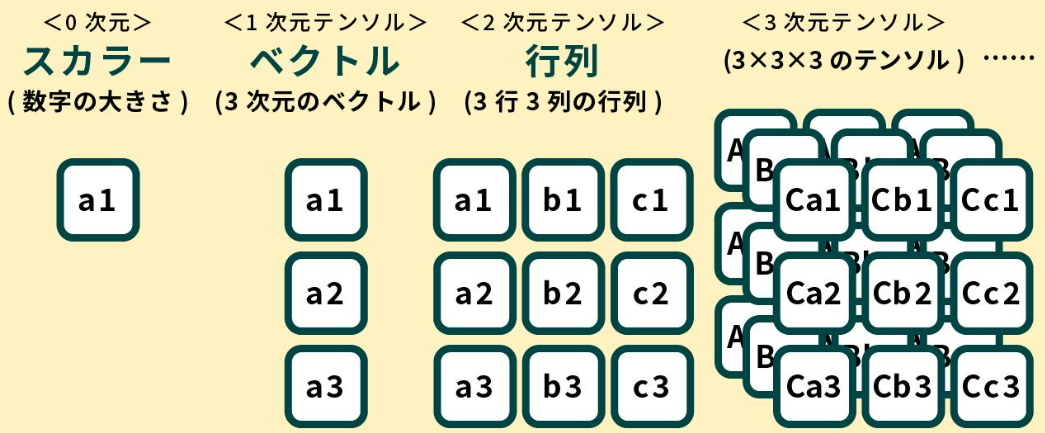

####torchvision.datasets.CIFAR10
* torchvision.datasets.CIFAR10: https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html
* CIFAR10のデータをロードするためのクラス

####PytorchのDataloader

* torch.utils.data.DataLoader: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

* datasetsからバッチごとに取り出すことを目的に使われます。
基本的にtorch.utils.data.DataLoaderを使います。

In [2]:
# 平均と標準偏差を用いてRGBの値を-1~1のテンソルに変換
transform = transforms.Compose(   #画像の前処理をtransforms.Compose()内で記述
    [transforms.ToTensor(),  #PIL Imageオブジェクトをテンソルに変換し、値の範囲を[0~255]から[0~1]にスケールします
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  #1番目の引数がRGBの各平均、2番目の引数が標準偏差、平均と標準偏差を用いて[-1~1]の範囲に正規化します

batch_size = 4  #2のn乗が利用されることが多い

# トレーニングデータをダウンロード
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# テストデータをダウンロード
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  #カテゴリ値とクラス名の対応付け: 0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'

100%|██████████| 170498071/170498071 [00:03<00:00, 47129866.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


トレーニング画像の一部を表示

pytorchでは画像データを(色のch, 高さ, 幅)で取り扱うので次元を入れ替えます。

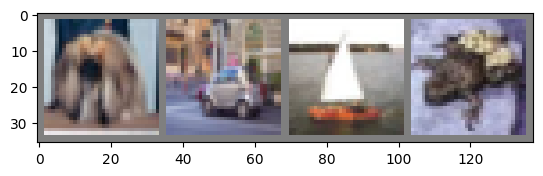

dog   car   ship  frog 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 画像を表示する関数

def imshow(img):
    img = img / 2 + 0.5     # 非正規化 入力をplt.imshowの[0,1]にあわせる
    npimg = img.numpy()  # NumPy配列に変換
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # （RGB、縦、横）から（縦、横、RGB）に並び替える
    plt.show()

# trainloderからデータのサンプルを取得/DataLoaderの中身の確認にはiterとnextを使用
dataiter = iter(trainloader) # iterで各バッチごとを読み出す
images, labels = next(dataiter) # nextで次々とバッチごとに画像とそのラベルを返す

# 画像を表示
imshow(torchvision.utils.make_grid(images)) # 複数の画像を横並びにして1枚の画像にします
# ラベルを表示
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))) # f’f文字列置換を行い join()関数により、一つの文字列に連結します

### 2. 畳み込みニューラルネットワークを定義
* Neural Networksセクションからニューラルネットワークをコピーし、（定義されている1チャンネル画像ではなく）3チャンネル画像を取り込むように修正します。
* **init**で各層を定義し、**forward**で繋げて利用します。

モデルの定義
* 画像を扱うタスクでは、畳み込みニューラルネットワーク(Convolutional Neural Network︓CNN)が有効とされています。
* 畳み込みニューラルネットワークとは「畳み込み層」と「プーリング層」を重ねたニューラルネットワークです。
* 畳み込み層では小さなフィルタ（カーネル）を使って入力の特徴を抽出します。
* プーリング層はMax（最大値）プーリングやAverage（平均）プーリングといった種類があり、情報の最大値や平均値を求めることで情報を集約します。
* 画像を扱う場合は特徴をより際⽴たせたいので、Maxプーリングを用いることが多いです。
* 10 クラスに分類するので、出力層の最後の層のユニット数は 10 を指定します。

####Building Models with PyTorch
* https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

####**Networkの定義**
* https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c
* https://kdl-di.hatenablog.com/entry/2021/12/24/090000

torch.nn.Linear: https://atmarkit.itmedia.co.jp/ait/articles/2002/06/news025.html
* レイヤ（層）を定義しているtorch.nn.Linearクラスは「入力データに対して線形変換を行うこと」を意味し、一般的には全結合層（Fully Connected Layer）と呼ばれており、ライブラリによっては「Dense層」（Kerasなど）や「Affine層」（Neural Network Consoleなど）とも呼ばれています。
* Linearクラスのコンストラクタ（厳密には__init__関数）の第1引数と第2引数には、入力ユニット数と出力ユニット数を指定すればよい。

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# AIモデルの定義
class Net(nn.Module): #Netというクラスを親クラスのnn.Moduleを継承する形で定義

    # レイヤ（層）を定義
    def __init__(self): #変数の初期化(コントラクタ)
        super().__init__() #親クラスを初期化/super()関数は継承されたクラスのメソッドを呼び出すために使用されます
        self.conv1 = nn.Conv2d(3, 6, 5)  #畳込みの定義(入力チャンネル数3,出力チャンネル数6,カーネルサイズ5)
        self.pool = nn.MaxPool2d(2, 2)   #poolingの定義(カーネルサイズ2×2)
        self.conv2 = nn.Conv2d(6, 16, 5) #畳込みの定義(入力チャンネル数6,出力チャンネル数16,カーネルサイズ5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  #全結合層の定義(フィルター数/Channel16×Height5×Width5(5×5の特徴画像が16枚),出力サイズ120)
        self.fc2 = nn.Linear(120, 84)  #全結合層の定義(入力サイズ120,出力サイズ84)
        self.fc3 = nn.Linear(84, 10)   #全結合層の定義(入力サイズ84,出力サイズ10(出力10個で、確率大のlabelに分類))

    # __init__()で記述したレイヤ（層）を用いて計算の流れを定義
    def forward(self, x): #層の定義後、実行する関数/xは入力データ
        x = self.pool(F.relu(self.conv1(x))) #F.relu=relu関数/conv1→relu→pool
        x = self.pool(F.relu(self.conv2(x))) #F.relu=relu関数/conv2→relu→pool
        x = torch.flatten(x, 1) #一次元化し、結合層に入力
        x = F.relu(self.fc1(x)) #線形層:活性化関数「ReLU」を使用
        x = F.relu(self.fc2(x)) #線形層:活性化関数「ReLU」を使用
        x = self.fc3(x) #線形層:結果をfc3に投入
        return x #最終結果を出力

# AIを宣言/インスタンスを生成
net = Net()  #子クラスのインスタンス化（オブジェクト化）

### 3. 損失関数と最適化関数を定義
* 最適化関数の種類(SGD,Adam)や学習率(lr)は精度Upを模索するために人が調整するハイパーパラメータ
* Momentumは、確率的勾配降下法に慣性項を付け加えたアルゴリズムです。
慣性とは、ある物体に外力が働かない場合、その物体の運動状態は変わらない性質のことです。

In [5]:
import torch.optim as optim
# 損失関数 クロスエントロピーロスは多クラス分類で使う損失
criterion = nn.CrossEntropyLoss()
# 最適化関数 SGDかAdamが使われることが多い (Stochastic Gradient Descent):確率的勾配降下法
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #momentum（慣性項）では、SGDのmomentumを設定することができます。デフォルトは momentum=0

### 4. ネットワークを訓練/構築したCNNの学習

In [6]:
for epoch in range(2):  #学習回数/epoch2回

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #enumerateでインデックス番号、要素の順に取得
        # 学習データと教師ラベルデータを取得
        inputs, labels = data

        # 勾配をゼロにする/勾配初期化
        optimizer.zero_grad()

        # 学習（forward + backward + optimize）
        outputs = net(inputs) #訓練データをCNNに入力
        loss = criterion(outputs, labels) #CNNからの出力outputsと実際の答えlabelsとの間の交差エントロピーを計算
        loss.backward() #損失関数lossに対してloss.backward()を実行すれば勾配を自動的に計算
        optimizer.step() #loss.backward()で計算した勾配をもとにパラメータを更新

        # 結果を表示
        running_loss += loss.item() #ロスを加算
        if i % 2000 == 1999:    #％は剰余演算子（割り算の余りを返します）2000ミニバッチ毎のLossの平均値を表示
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.219
[1,  4000] loss: 1.867
[1,  6000] loss: 1.682
[1,  8000] loss: 1.580
[1, 10000] loss: 1.512
[1, 12000] loss: 1.445
[2,  2000] loss: 1.381
[2,  4000] loss: 1.371
[2,  6000] loss: 1.314
[2,  8000] loss: 1.323
[2, 10000] loss: 1.286
[2, 12000] loss: 1.262
Finished Training


In [7]:
# 学習したモデル(CNN)ををcifar_net.pthという名前で保存
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH) #モデルのパラメータを取り出すには、net.state_dict()を使います

### 5. 学習済みCNNをテストデータで評価

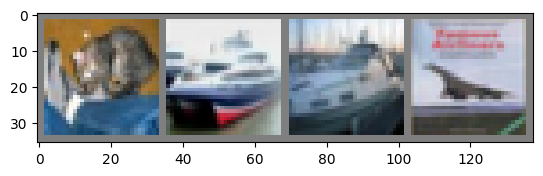

GroundTruth:  cat   ship  ship  plane


In [8]:
# テストデータを読み込み、画像と正解ラベルを表示
dataiter = iter(testloader)  # iterで各バッチごとを読み出す
images, labels = next(dataiter) # nextで次々とバッチごとに画像とそのラベルを返す
imshow(torchvision.utils.make_grid(images)) # 複数の画像を横並びにして1枚の画像にします
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4))) # f’f文字列置換を行い join()関数により、一つの文字列に連結します

In [9]:
# 保存したモデルを再び読み込み、4つの画像を予測
net = Net()
net.load_state_dict(torch.load(PATH)) #保存した学習済みのモデル(cifar_net.pth)を読み込みます
outputs = net(images) #読み込んだモデルに画像データを入力
_, predicted = torch.max(outputs, 1) #引数1は行方向の最大値を求めるという意味
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car  ship


<ipython-input-9-aa10fc067ba0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH)) #保存した学習済みのモデル(cifar_net.pth)を読み込みます


このモデルがすべてのテストデータを用いてどれくらいの精度で予測できるかを確認します。

In [10]:
correct = 0
total = 0
# 学習の時以外は勾配の計算は不要なのでOFF
with torch.no_grad(): #勾配を初期化
    for data in testloader: #testloaderに格納されているバッチデータを1づつ取り出してdataに格納
        images, labels = data #検証データと教師ラベルデータを取得
        outputs = net(images) #検証データをモデルに渡し予測
        _, predicted = torch.max(outputs.data, 1) #予測確率が一番高いものを採用し精度を算出
        total += labels.size(0) #トータル数をカウントします
        correct += (predicted == labels).sum().item() #正解数をカウントします

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


10000枚のテストデータに対する正解率は56%

各クラス毎の正解率を見てみます。

In [11]:
# 各クラスの予想を数える準備
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 勾配の計算は不要
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 各クラスの正しい予測を集める
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 各クラスの精度を表示
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.2 %
Accuracy for class: car   is 80.8 %
Accuracy for class: bird  is 53.6 %
Accuracy for class: cat   is 24.0 %
Accuracy for class: deer  is 56.8 %
Accuracy for class: dog   is 54.7 %
Accuracy for class: frog  is 53.6 %
Accuracy for class: horse is 60.0 %
Accuracy for class: ship  is 72.5 %
Accuracy for class: truck is 48.9 %


高い正解率: carの80.8%、低い正解率: catの24.0%